In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [2]:
def import_basel_data():
    data = pd.read_csv("../raw_data/Basel_Daten.csv", delimiter=';')
    return data

def get_location_data(df, location):
    mask = df['SiteName'] == location
    return df[mask], df[~mask]

def clean_location_data(location_df):
    stamps = [x.split('+')[0] for x in location_df['DateTimeFrom'].values]
    location_df = location_df.assign(Time=pd.to_datetime(stamps.copy(), format="%Y-%m-%dT%H:%M:%S"))
    location_df = location_df.set_index('Time')
    location_df = location_df.assign(Day=location_df.index.day)
    return location_df

def get_location_split_dict(data):
    location_dict = {}
    #Alle Orte
    locs = sorted(list(set(data['SiteName'])))
    for loc in locs:
        location_df, data = get_location_data(data, loc)
        location_dict[loc] = clean_location_data(location_df)
    return location_dict

def resample_location_data(location_df, frequency):
    if frequency == 'D':
        cols = ['Total']
    elif frequency == 'H':
        cols = ['Total', 'Month', 'Day', 'Weekday', 'HourFrom']
    else:
        print("INCORRECT FREQUENCY")
    location_df = location_df[cols].resample(frequency).sum()
    return location_df

In [3]:
data = import_basel_data()
location_hourly_sum = {}
location_daily_sum = {}
locs = sorted(list(set(data['SiteName'])))
print(locs)
for loc, loc_data in get_location_split_dict(data).items():
    location_daily_sum[loc] = resample_location_data(loc_data, 'D')    
    location_hourly_sum[loc] = resample_location_data(loc_data, 'H')

['350 Dreirosenbrücke', '352 Johanniterbrücke', '354 Wettsteinbrücke', '403 Heuwaage-Viadukt', '405 Dorenbachviadukt', '659 Schlachthofstrasse', '660 Flughafenstrasse', '802 Klybeckstrasse 113/Kirche', '803 Johanniterbrücke', '804 Rosentalstrasse 29/28', '805 Rebgasse 11/28', '806 Gerbergasse', '807 Güterstrasse 180/183', '808 Wolfschlucht-Promenade', '809 Allschwilerstrasse 77/86', '810 Neubadstrasse 124/137', '811 Mülhauserstrasse 110/122', '812 Wettsteinbrücke', '813 Hardstrasse 66/77', '814 Elisabethenstrasse 46*', '815 Mittlere Rheinbrücke', '816 Schmiedgasse 4/7 (Riehen)', '817 Elisabethenanlage', '901 Peter-Merian Weg', '902 Viaduktstrasse', '903 Äussere Baselstrasse 328', '904 Hammerstrasse 90', '905 Leimenstrasse 4', '906 Hegenheimerstrasse 44', '907 Wasgenring 62', '908 Grenzacherstrasse (Kraftwerk)', '909 General Guisan-Strasse 104', '910 St. Galler-Ring 101', '911 Birskopfsteg', '912 Elsässerstrasse 261/260', '913 Burgfelderstrasse', '914 Hiltalingerstrasse', '915 Luzernerr

In [4]:
location_daily_sum['802 Klybeckstrasse 113/Kirche'].head()

,Total
Time,
2019-01-31,146
2019-02-01,1639
2019-02-02,2025
2019-02-03,836
2019-02-04,1808


In [5]:
location_hourly_sum['802 Klybeckstrasse 113/Kirche']

,Total,Month,Day,Weekday,HourFrom
Time,,,,,
2019-01-31 20:00:00,41,1,31,3,20
2019-01-31 21:00:00,48,1,31,3,21
2019-01-31 22:00:00,39,1,31,3,22
2019-01-31 23:00:00,18,1,31,3,23
2019-02-01 00:00:00,13,2,1,4,0
...,...,...,...,...,...
2019-09-30 20:00:00,102,9,30,0,19
2019-09-30 21:00:00,59,9,30,0,20
2019-09-30 22:00:00,37,9,30,0,21


In [6]:
%matplotlib inline

def location_plot(adresse, show=False, ax2=None):

    plotdata = location_hourly_sum[adresse]
    data_by_day = {"%d:%d"%(mk,dk):dv.sort_values(by=['HourFrom']) for mk, mv in plotdata.groupby('Month')
                                                                         for dk, dv in mv.groupby('Day')}

    if show:
        fig, ax = plt.subplots(4,2, figsize=(10,13))
        #Flatten
        ax = [x for y in ax for x in y]
    mean = np.zeros((7,24))
    numb = np.array(7*[0])
    
    for i in range(1, len(data_by_day)):
        vals = list(data_by_day.values())[i]
        thisday = vals['Weekday'].values[0]
        if len(vals['Weekday'].values) == 24:
            numb[thisday] += 1
            mean[thisday,:] += np.array(list(data_by_day.values())[i]['Total'].values)
            if show:
                ax[thisday].plot(list(data_by_day.values())[i]['Total'].values, alpha=0.3, c='blue')

    showLater = True
    if ax2==None:
        showLater = False
        fig, ax2 = plt.subplots(figsize=(10,8))
    mean = mean/np.reshape(numb,(7,1))
    cs=5*['blue']+['orange']+['red']
    for i in range(7):
        ax2.plot(mean[i], c=cs[i])
    if not showLater:
        ax2.legend(['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag'])
        plt.show()
    
    return mean

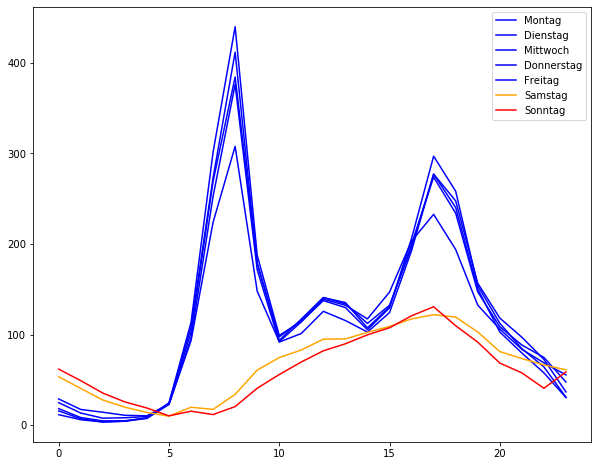

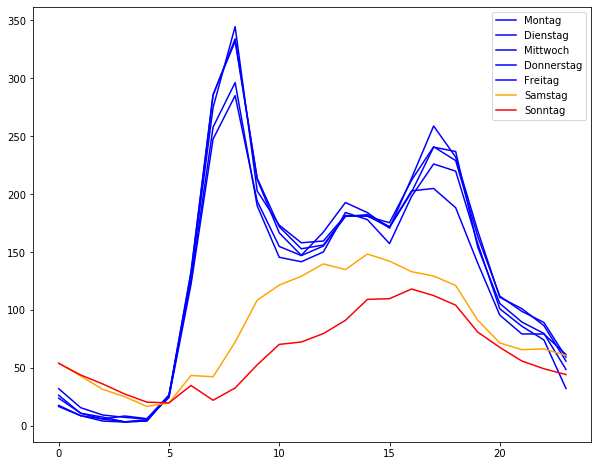

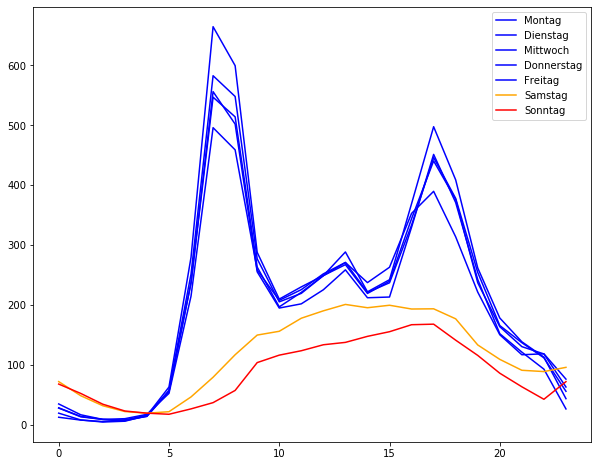

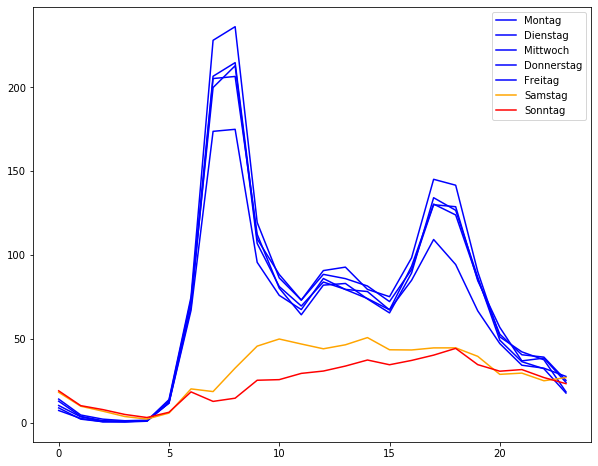

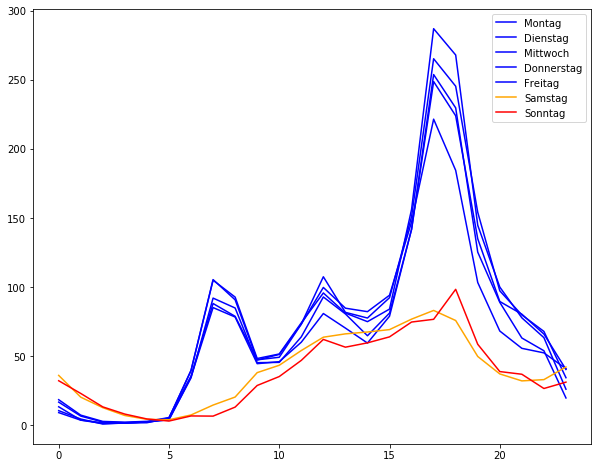

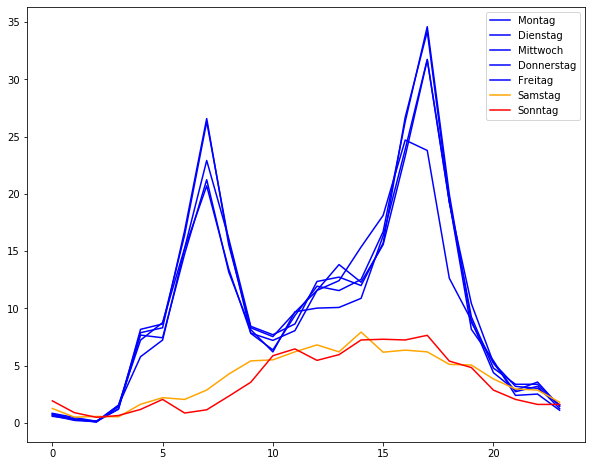

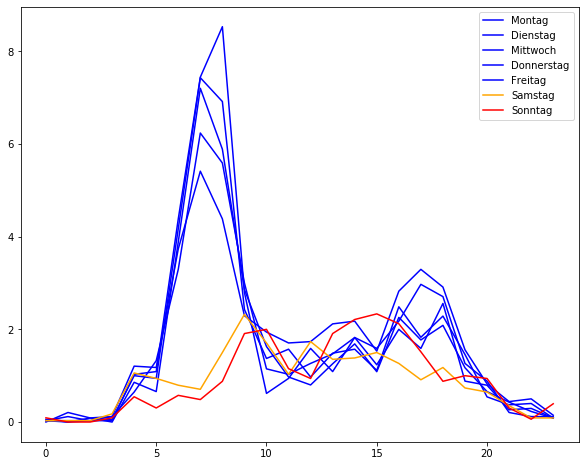

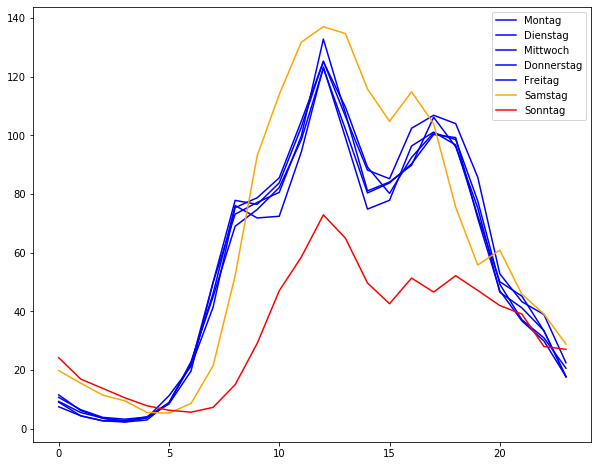

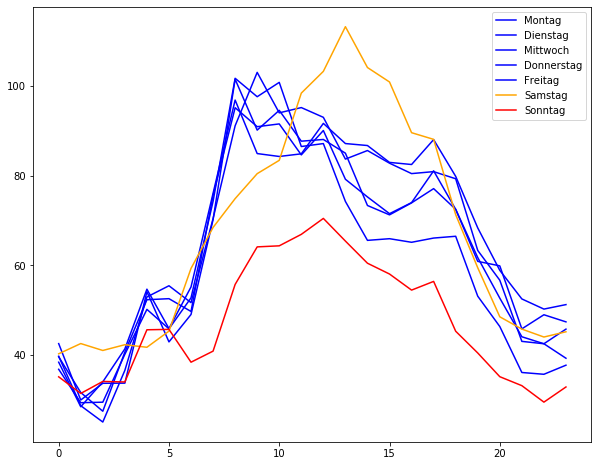

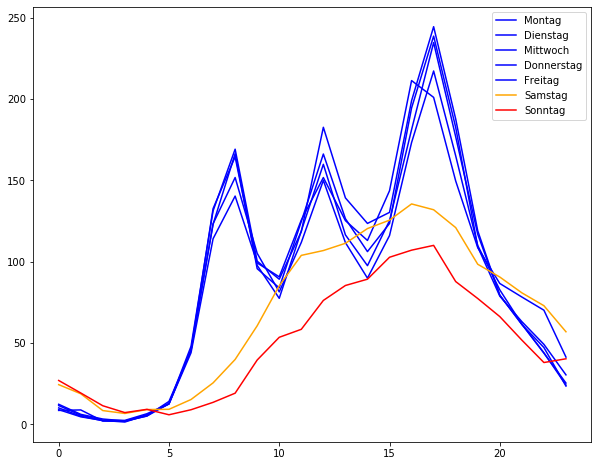

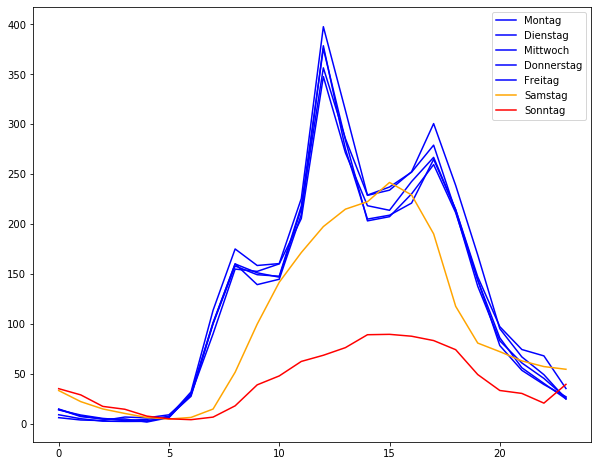

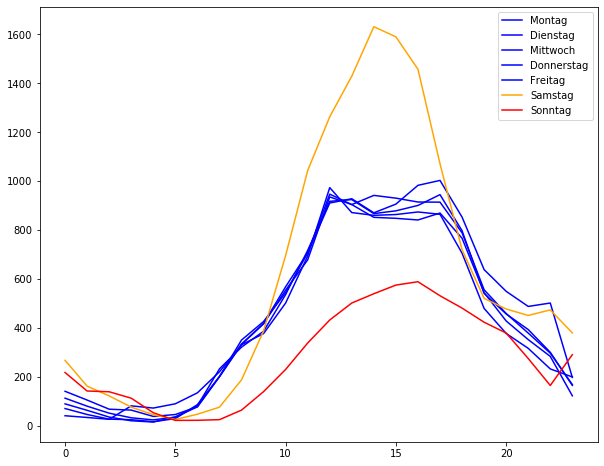

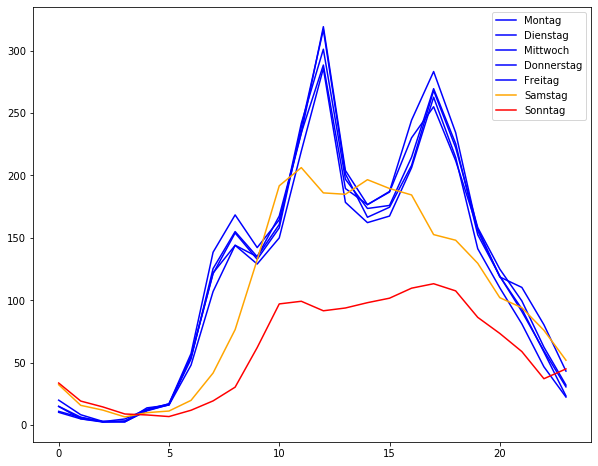

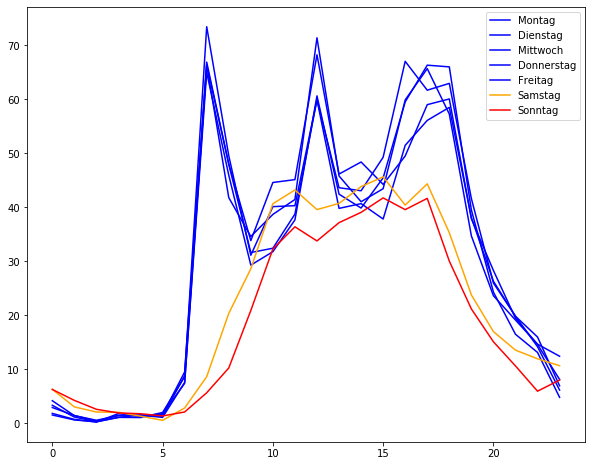

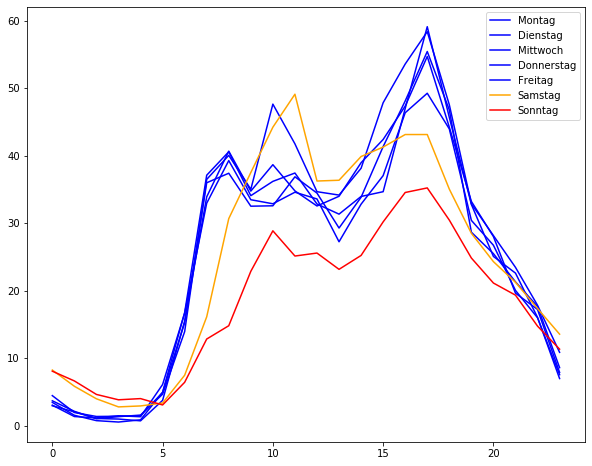

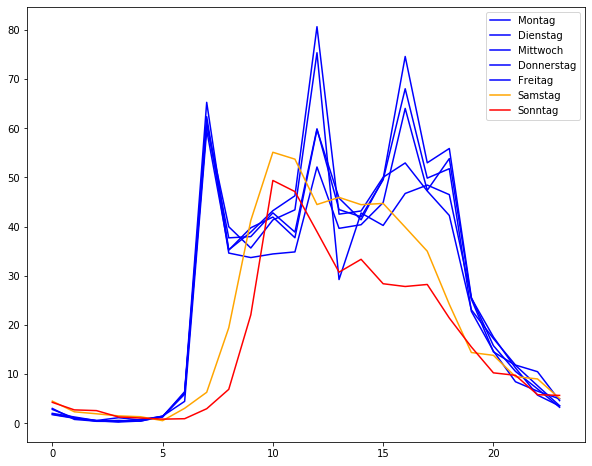

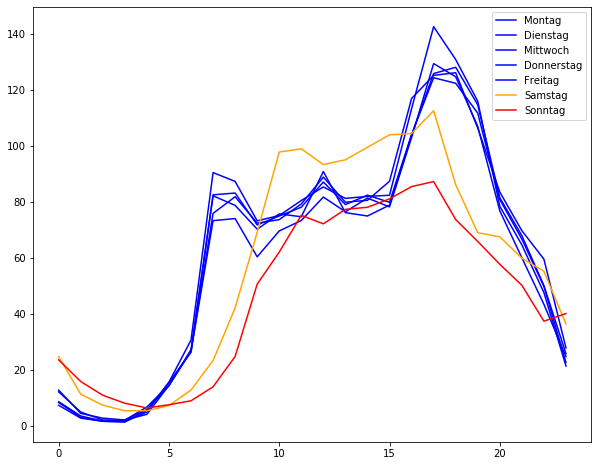

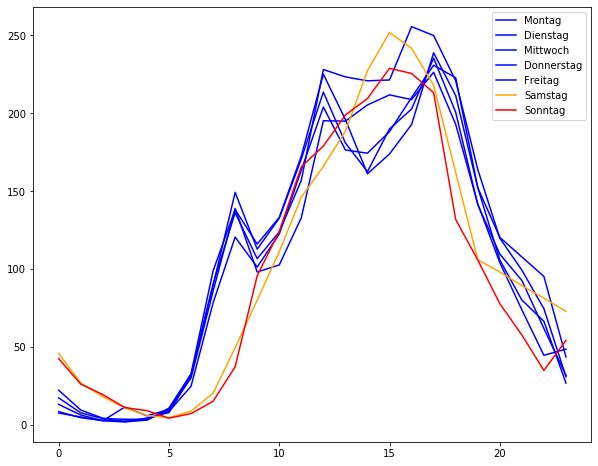

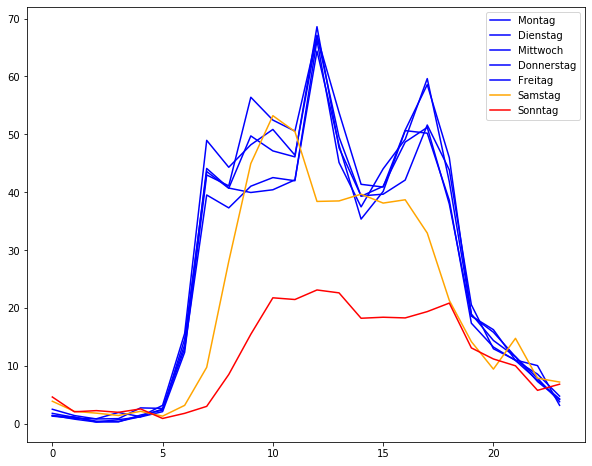

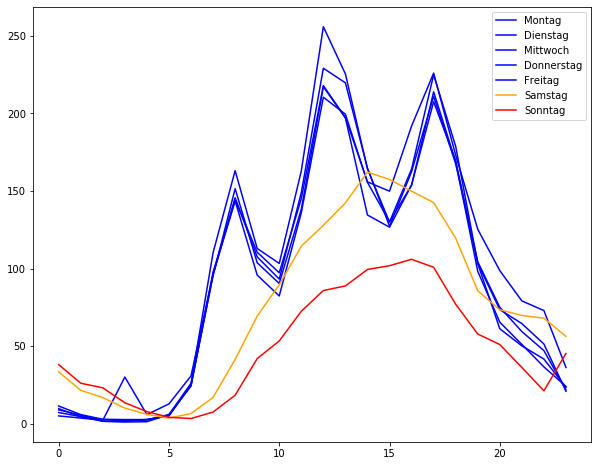

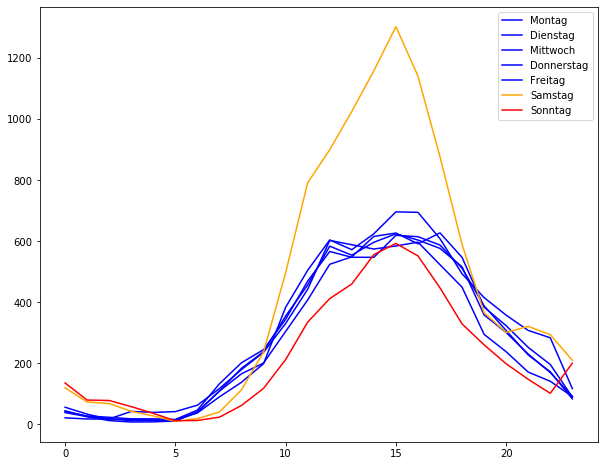

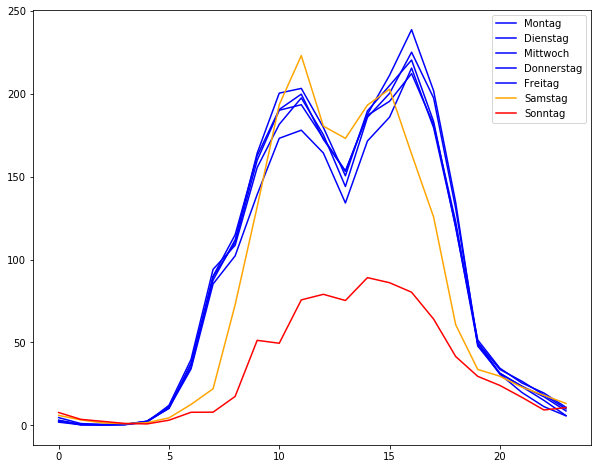

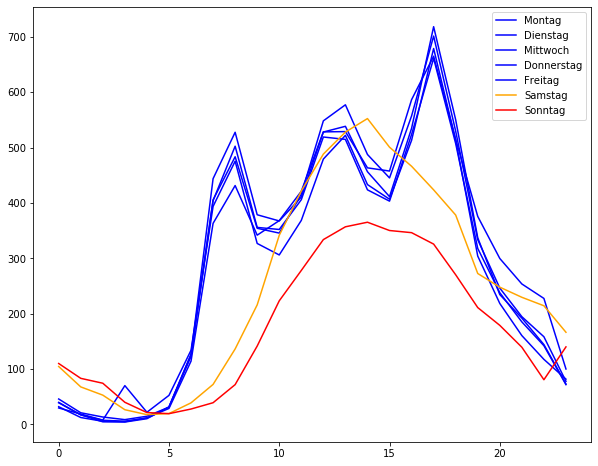

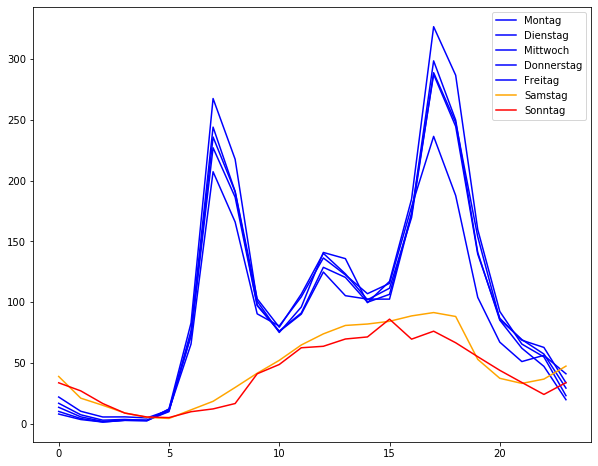

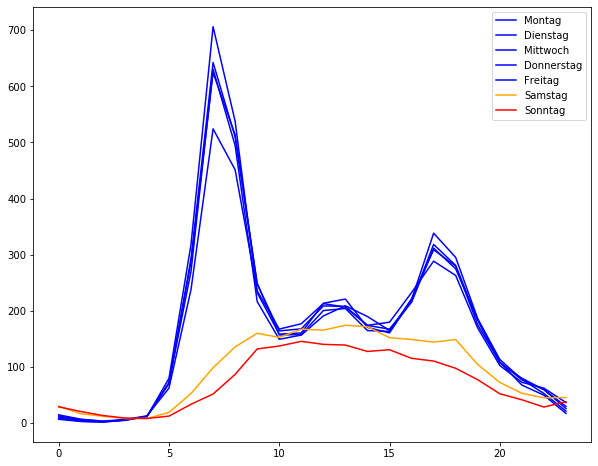

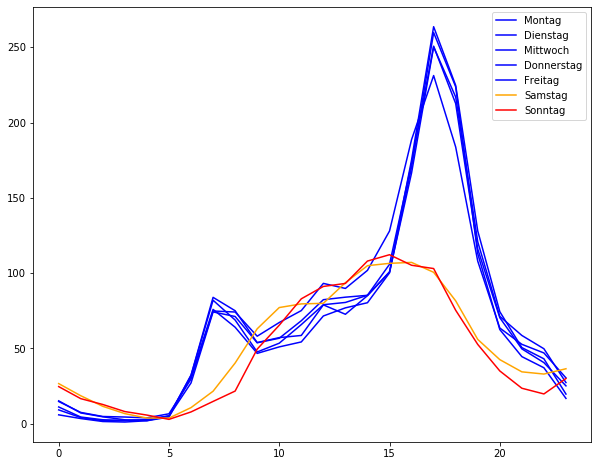

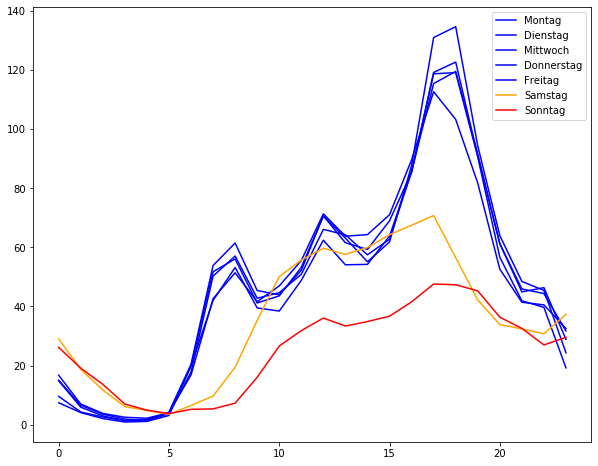

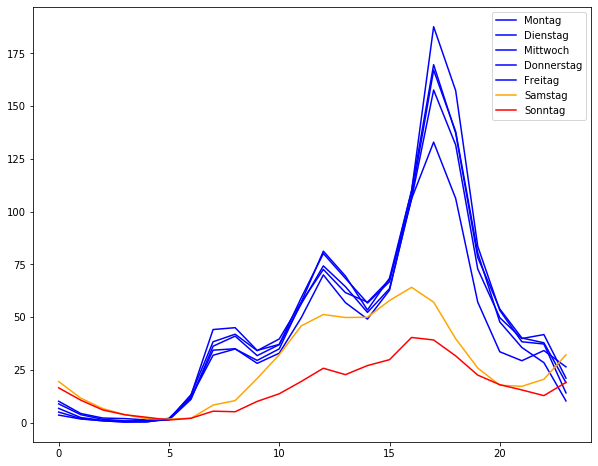

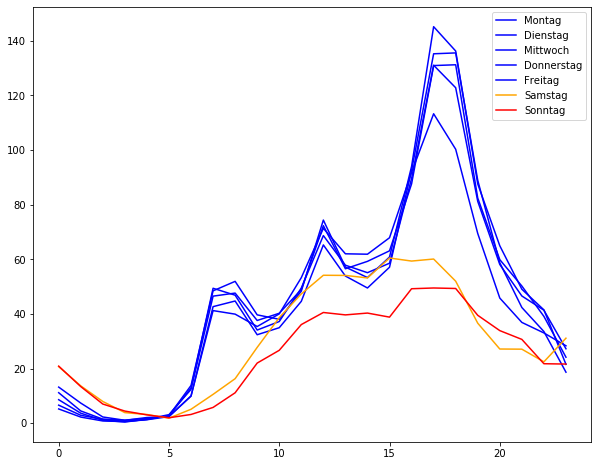

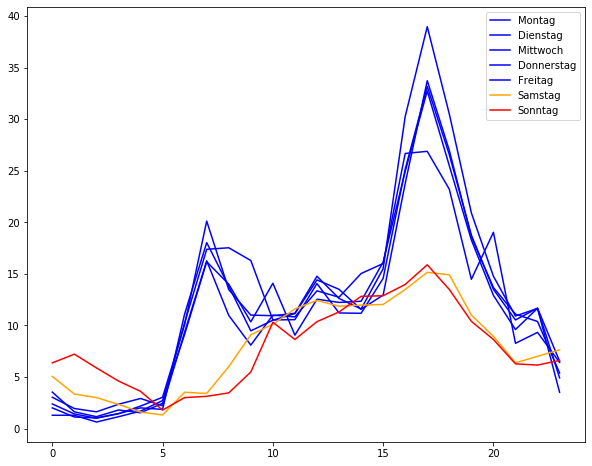

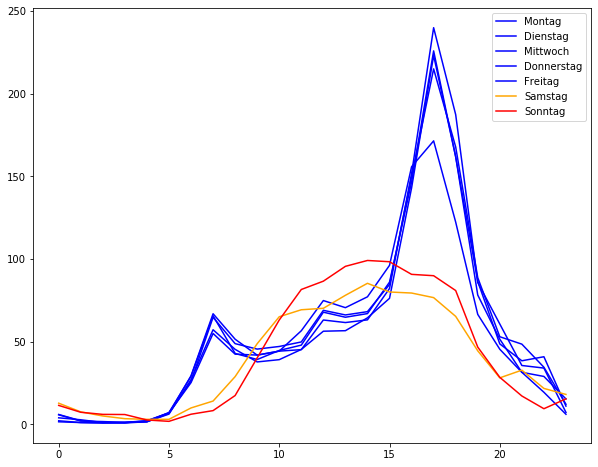

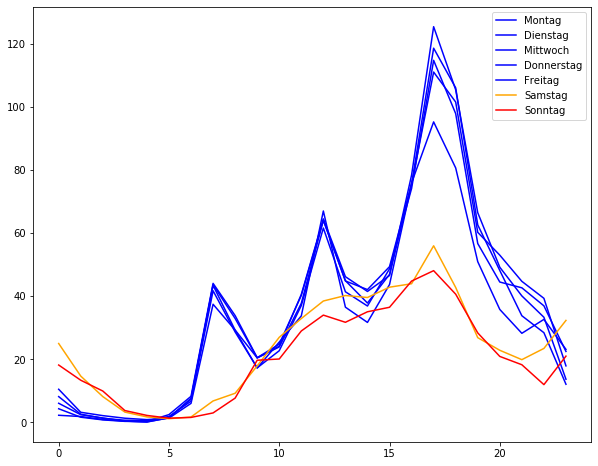

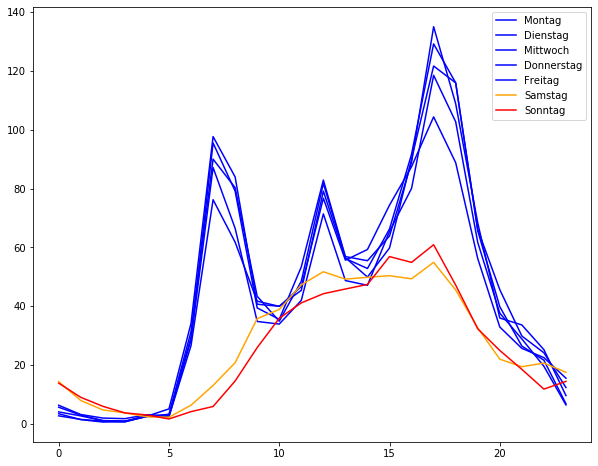

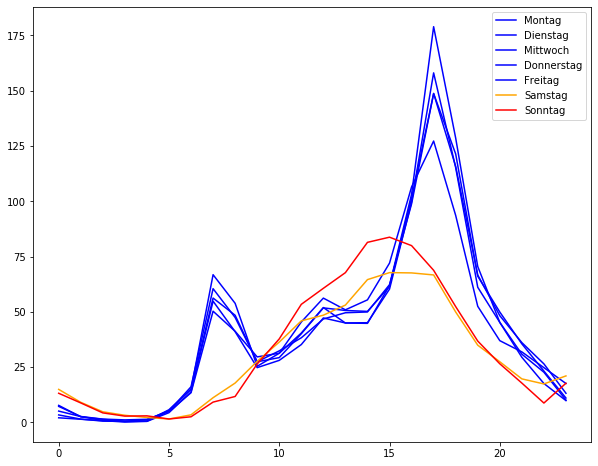

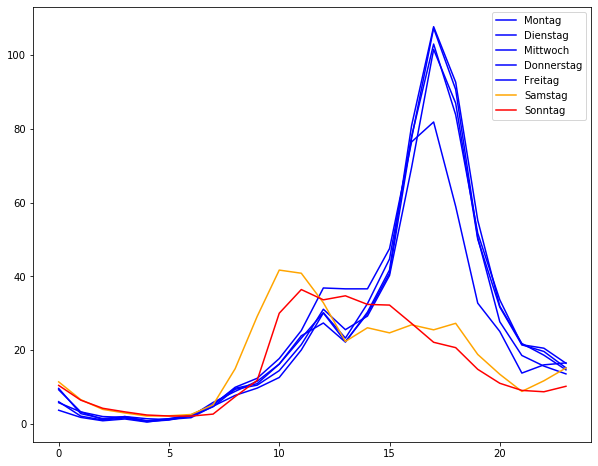

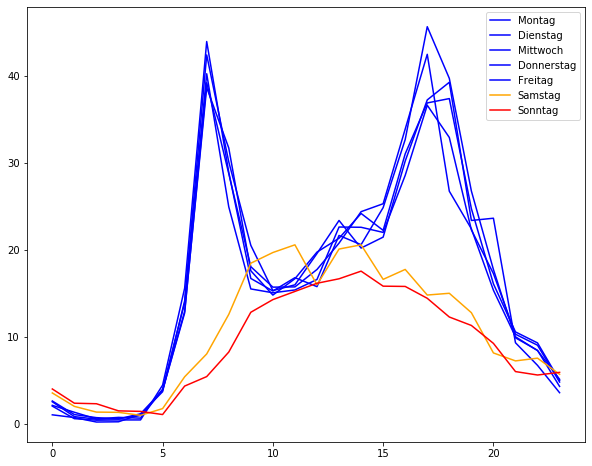

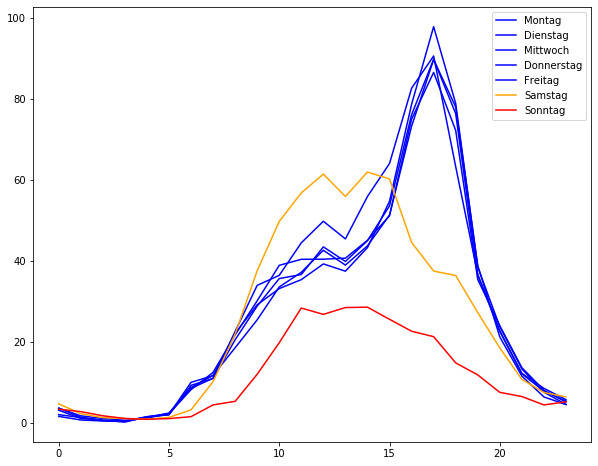

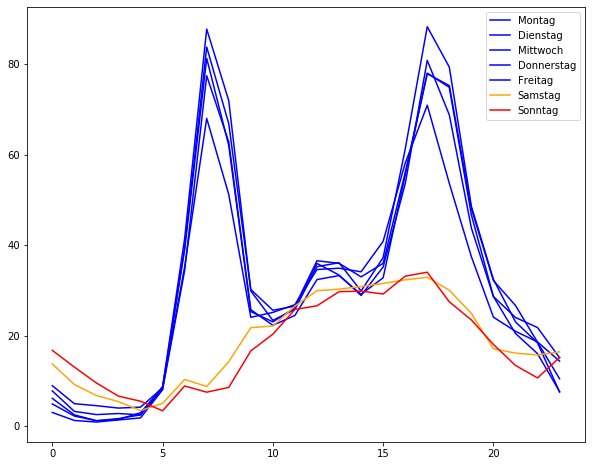

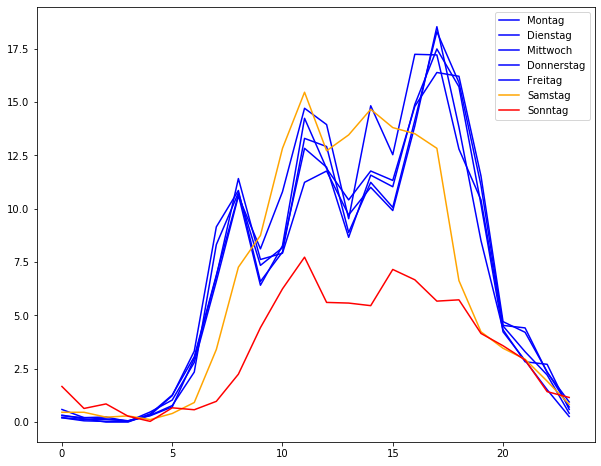

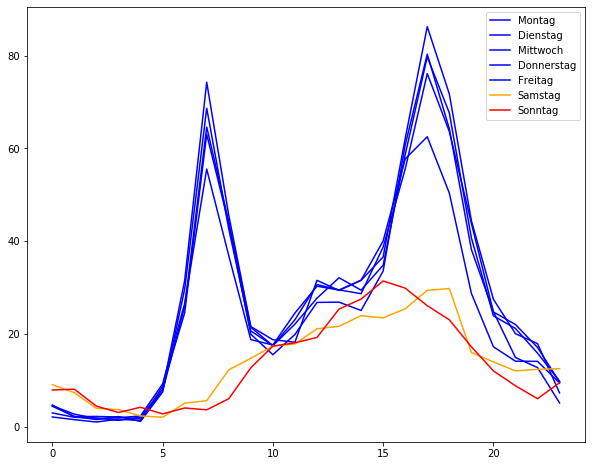

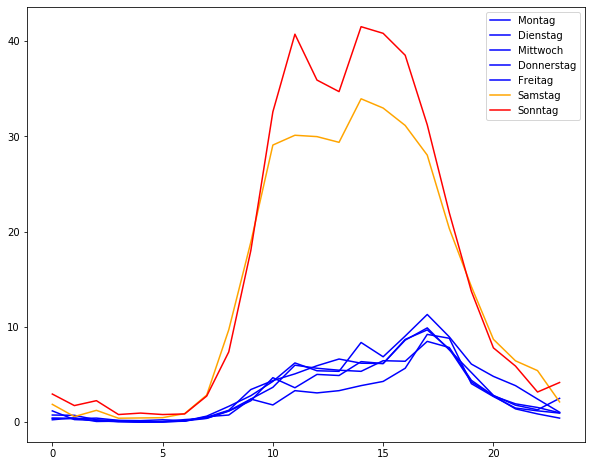

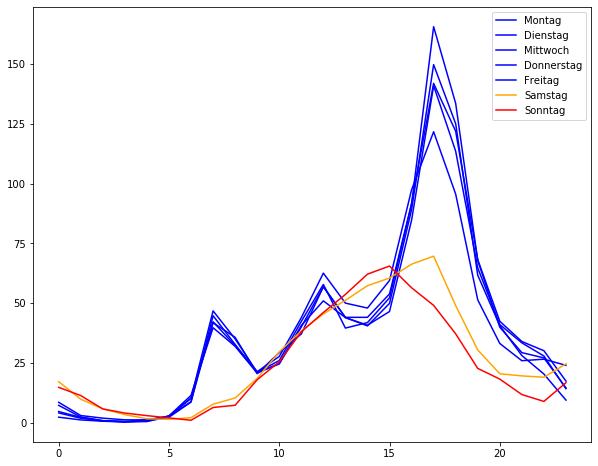

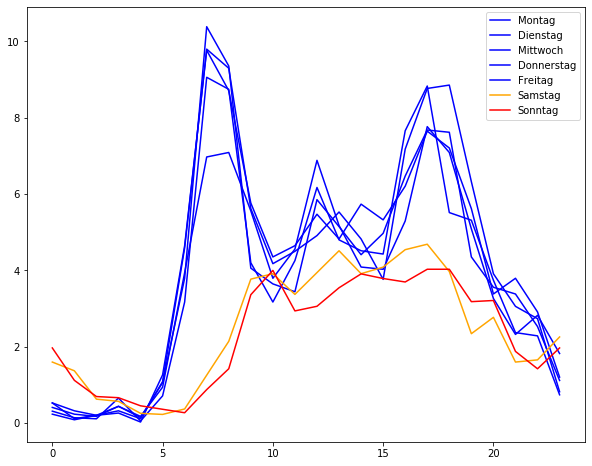

In [7]:
X = [location_plot(loc) for loc in locs]

In [8]:
#Factor 1/11 - 3/11
Z = (np.array(X) * np.array(43 * [[24*[1],24*[1],24*[1],24*[1],24*[1],24*[3],24*[3]]])).reshape((43,168))
#Z = np.array(X).reshape((43,168))
#Z * np.array(43*[0])
mz = np.mean(Z, axis=1)
Z = Z/np.reshape(mz,(43,1))

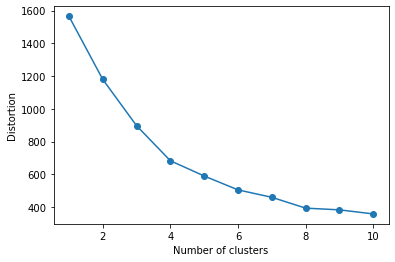

In [9]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(Z)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [10]:
def cluster_locations(i, j):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(Z)
    results = km.predict(Z)
    wow = [list(np.array(locs)[results == j]) for j in range(i)]
    #print(wow)
    
    fig,ax = plt.subplots(i,j, figsize=(7*i,4*j))
    for a in range(i):
        for b in range(j):
            if b < len(wow[a]):
                location_plot(wow[a][b], ax2=ax[a,b])

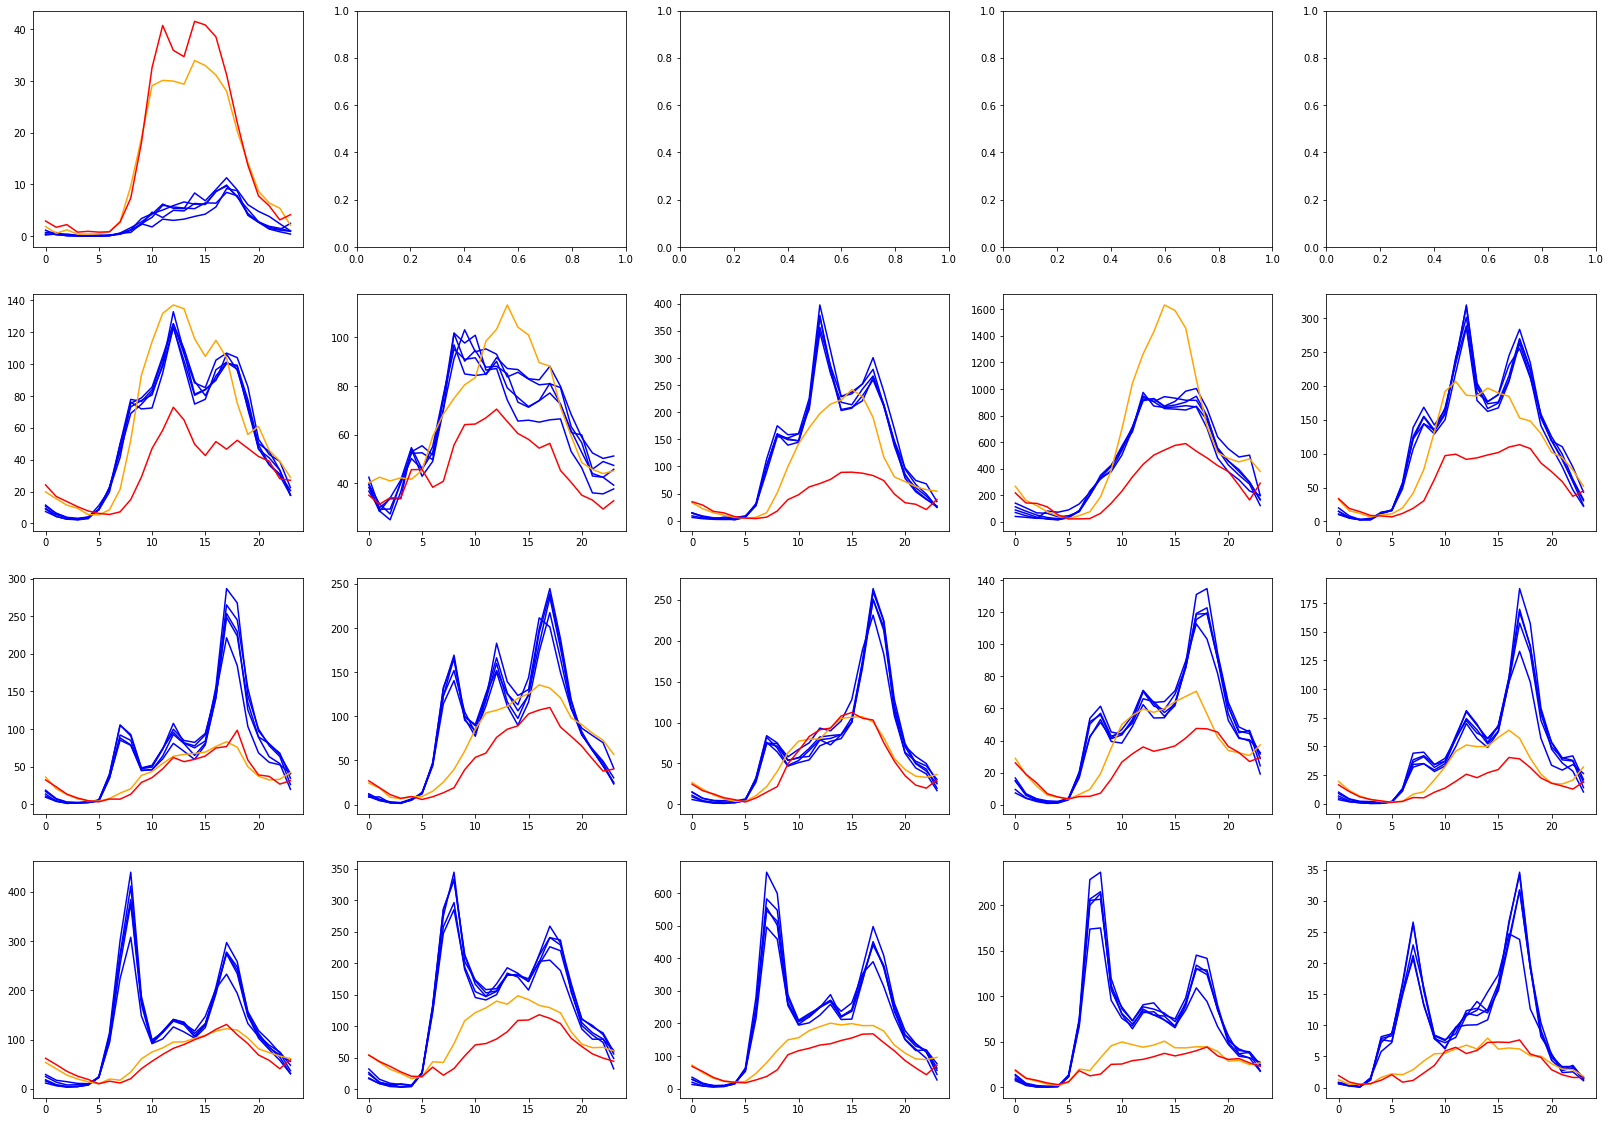

In [11]:
cluster_locations(4,5)